# What Gravitational wave Template fits GW150914 the best? #

Try to fit the LIGO detector data of the GW150914 binary black hole merger to a gravitational-wave template. You can adjust the masses and the spin of the template with the sliders below and see how well it matches up to the data, and how much signal-to-noise you are able to extract.

In [5]:
import pycbc.types
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

ifos = ['H1', 'L1']
m = Merger("GW150914")

# Load in the detector data
data = {ifo:pycbc.types.load_timeseries('gw150914.hdf', group=ifo).time_slice(m.time-8, m.time+8) for ifo in ifos}    

# Calculate the power spectral density for each ifo
psd = {}
for ifo in ifos:
    psd[ifo] = interpolate(data[ifo].psd(4), data[ifo].delta_f)
    psd[ifo] = inverse_spectrum_truncation(psd[ifo], 4 * data[ifo].sample_rate,
                                           low_frequency_cutoff=15.0)

# Create a whitened version of the data for plotting
wdata = {}
for ifo in ifos:
    wdata[ifo] = data[ifo].whiten(4, 4).lowpass_fir(300, 1024).highpass_fir(30, 1024)

In [6]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.filter import sigma

def make_snr(ifo, m1, m2, s12):
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, spin1z=s12, spin2z=s12,
                             f_lower=25, delta_f=data[ifo].delta_f)
    hp.resize(len(data[ifo])/2+1)
    
    snr = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=30.0)
    snr = snr.time_slice(m.time - 1, m.time + 1)
    
    # Scale template to peak time, phase and amplitude
    a = snr.abs_arg_max()
    spm = snr[a]
    dt = snr.sample_times[a] - data[ifo].start_time
    hp.start_time = data[ifo].start_time + dt
    snr.template = (hp / sigma(hp, psd=psd[ifo], low_frequency_cutoff=30.0) * spm).cyclic_time_shift(dt)
    
    # Whiten the and bandpass the template as we've done to the data
    snr.template = (snr.template / psd[ifo] ** 0.5).to_timeseries()
    snr.template = snr.template.crop(4, 4).lowpass_fir(300, 1024).highpass_fir(30, 1024)
    
    return snr

<IPython.core.display.Javascript object>


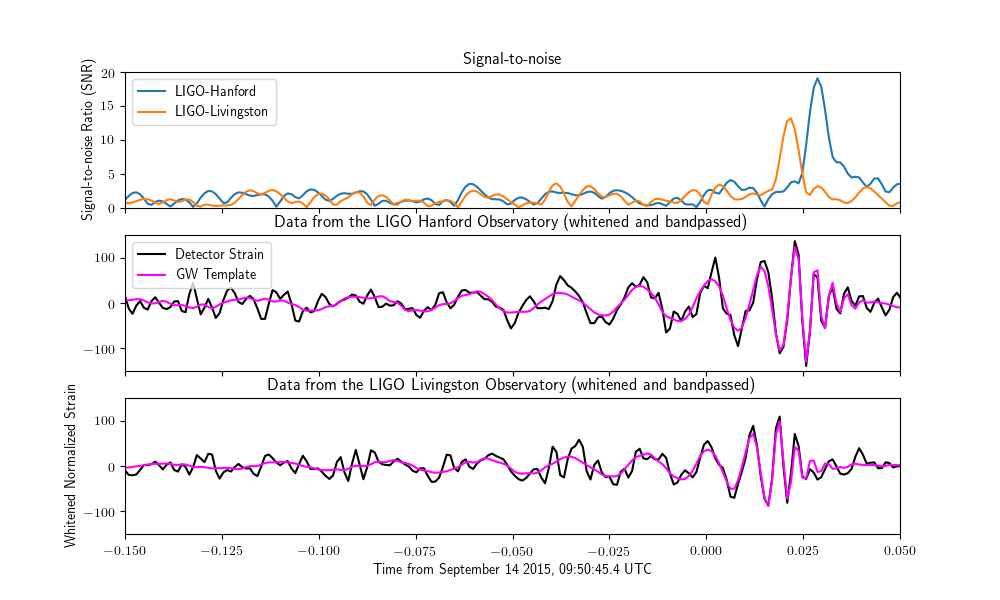

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIwLjAsIGNvbnRpbnVvdXNfdXBkYXRlPUZhbHNlLCBkZXNjcmlwdGlvbj11JyRNXzEgKE1fXFxvZG90JCknLCBsYXlvdXTigKY=


In [7]:
%matplotlib notebook
import pylab
import ipywidgets as gui

pax = {}
fig, (ax1, pax['H1'], pax['L1']) = pylab.subplots(3, 1, figsize=[10, 6], sharex=True)
ax1.set_ylim(0, 20)
lines = {}
lt = {}

labels={'L1':"LIGO-Livingston", 'H1':'LIGO-Hanford'}

rtime =  1126259462.4
ttext = "September 14 2015, 09:50:45.4 UTC"

for ifo in ifos:
    snr = make_snr(ifo, 37, 37, 0)
    lines[ifo], = ax1.plot(snr.sample_times.numpy()-rtime, abs(snr).numpy(), label=labels[ifo])    
    pax[ifo].plot(wdata[ifo].sample_times-rtime, wdata[ifo], color='black', label='Detector Strain')
    lt[ifo], = pax[ifo].plot(snr.template.sample_times-rtime, snr.template, color='magenta', label='GW Template')
    pax[ifo].set_ylim(-150, 150)
    
ax1.legend(loc='upper left')
pylab.xlim(-0.15, +0.05)

ax1.set_title('Signal-to-noise')
ax1.set_ylabel("Signal-to-noise Ratio (SNR)")

pax['H1'].legend(loc='upper left')
pax['L1'].set_ylabel('Whitened Normalized Strain')
pax['H1'].set_title('Data from the LIGO Hanford Observatory (whitened and bandpassed)')
pax['L1'].set_title('Data from the LIGO Livingston Observatory (whitened and bandpassed)')
pax['L1'].set_xlabel('Time from %s' % ttext)

def plot(m1, m2, s12):
    for ifo in ifos:
        snr = make_snr(ifo, m1, m2, s12)
        lines[ifo].set_ydata(abs(snr).numpy())
        lt[ifo].set_ydata(snr.template.numpy())
        
    fig.canvas.draw_idle()

mslider = gui.FloatSlider(value=20, max=100, min=20,
                                readout_format='.1f',
                                layout=gui.Layout(width='100%'),
                                description='$M_1 (M_\odot$)',
                                step=0.5, continuous_update=False)
mslider2 = gui.FloatSlider(value=20, max=100, min=20,
                                readout_format='.1f',
                                layout=gui.Layout(width='100%'),
                                description='$M_2 (M_\odot$)',
                                step=0.5, continuous_update=False)
spinslider = gui.FloatSlider(value=0, max=.95, min=-.95,
                                readout_format='.2f',
                                layout=gui.Layout(width='100%', height='100%'),
                                description='Spin',
                                step=0.05, continuous_update=False)
out = gui.interact(plot, m1=mslider, m2=mslider2, s12=spinslider)